In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("lcdb.csv")
df

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,score_train,score_valid,score_test
0,6,SVC_linear,16,2000,0,0,1.0000,0.1728,0.1840
1,6,SVC_linear,23,2000,0,0,1.0000,0.1939,0.1975
2,6,SVC_linear,32,2000,0,0,1.0000,0.2400,0.2385
3,6,SVC_linear,45,2000,0,0,0.9556,0.2478,0.2515
4,6,SVC_linear,64,2000,0,0,0.9844,0.3150,0.3030
...,...,...,...,...,...,...,...,...,...
1765441,1566,sklearn.tree.ExtraTreeClassifier,181,122,4,4,1.0000,0.5596,0.4754
1765442,1566,sklearn.tree.ExtraTreeClassifier,256,122,4,4,1.0000,0.5138,0.4836
1765443,1566,sklearn.tree.ExtraTreeClassifier,362,122,4,4,1.0000,0.6239,0.5984
1765444,1566,sklearn.tree.ExtraTreeClassifier,512,122,4,4,1.0000,0.4771,0.5000


In [3]:
def get_mean_curves(df):
    rows = []
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = sorted(pd.unique(df_learner["size_train"]))
            scores = []
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes_seed, scores_seed = df_seeded["size_train"].values, df_seeded["score_valid"].values
                scores.append([scores_seed[list(sizes_seed).index(s)] if s in sizes_seed else np.nan for s in sizes])
            scores = np.array(scores)
            mean_scores = np.nanmean(scores, axis=0)
            rows.append([openmlid, learner, sizes, np.round(mean_scores, 4), np.round(1 - mean_scores, 4)])
    return pd.DataFrame(rows, columns=["openmlid", "learner", "sizes", "mean_accuracies", "mean_errorrates"])
            
df_mean_curves = get_mean_curves(df.query("inner_seed < 5"))

  0%|          | 0/202 [00:00<?, ?it/s]

In [17]:
learners = sorted(pd.unique(df["learner"]))
learner_names = [
    "SVC (linear)",
    "SVC (poly)",
    "SVC (rbf)",
    "SVC (sigm.)",
    "LDA", "QDA",
    "Extra Trees", "Grad. Boost",
    "RF", "LR", "PA", "Perceptron", "Ridge", "SGD",
    "Bernouli NB", "Multin. NB", "kNN",
    "MLP", "DT", "Extra Tree"
    
]
if len(learners) != len(learner_names):
    raise Exception()
", ".join([learners[i] + "(" + learner_names[i] + ")" for i in range(len(learners))])

'SVC_linear(SVC (linear)), SVC_poly(SVC (poly)), SVC_rbf(SVC (rbf)), SVC_sigmoid(SVC (sigm.)), sklearn.discriminant_analysis.LinearDiscriminantAnalysis(LDA), sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(QDA), sklearn.ensemble.ExtraTreesClassifier(Extra Trees), sklearn.ensemble.GradientBoostingClassifier(Grad. Boost), sklearn.ensemble.RandomForestClassifier(RF), sklearn.linear_model.LogisticRegression(LR), sklearn.linear_model.PassiveAggressiveClassifier(PA), sklearn.linear_model.Perceptron(Perceptron), sklearn.linear_model.RidgeClassifier(Ridge), sklearn.linear_model.SGDClassifier(SGD), sklearn.naive_bayes.BernoulliNB(Bernouli NB), sklearn.naive_bayes.MultinomialNB(Multin. NB), sklearn.neighbors.KNeighborsClassifier(kNN), sklearn.neural_network.MLPClassifier(MLP), sklearn.tree.DecisionTreeClassifier(DT), sklearn.tree.ExtraTreeClassifier(Extra Tree)'

# Shape Properties

## Monotonicity

In [5]:
def get_monotonicity_violations(df, column, is_increasing, min_size = 0):
    rows = []
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = np.array(df_learner["sizes"].values[0])
            indices = sizes >= min_size
            if np.count_nonzero(indices) < 3:
                continue
            relevant_sizes = sizes[indices]
            mean_accuracies = df_learner[column].values[0][indices]
            
            violations = []
            violation = 0
            violating_steps = 0
            for i, (a1, s1) in enumerate(zip(relevant_sizes[:-1], mean_accuracies[:-1])):
                a2 = relevant_sizes[i + 1]
                s2 = mean_accuracies[i + 1]
                violation_here = max(0, s2 - s1)
                if violation_here > 0:
                    violating_steps += 1
                violations.append(violation_here)
                violation += violation_here

            rows.append([openmlid, learner, violation / (len(sizes) - 1), violation / violating_steps if violating_steps > 0  else 0, max(violations)])
    return pd.DataFrame(rows, columns=["openmlid", "learner", "avg_violation", "avg_violation_conditional", "max_violation"])

In [6]:
df_monotonicityviolations_0 = get_monotonicity_violations(df_mean_curves, "mean_errorrates", False)
df_monotonicityviolations_64 = get_monotonicity_violations(df_mean_curves, "mean_errorrates", False, min_size = 64)
df_monotonicityviolations_128 = get_monotonicity_violations(df_mean_curves, "mean_errorrates", False, min_size = 128)
df_monotonicityviolations_256 = get_monotonicity_violations(df_mean_curves, "mean_errorrates", False, min_size = 256)

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

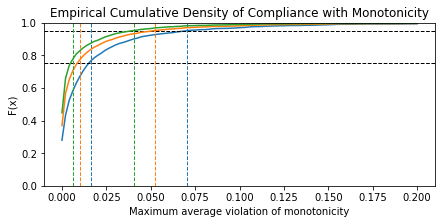

In [7]:
max_violations = np.linspace(0, 0.2, 100)
ecdf_violations_monotonicity = {
    i: np.array([len(df[df["max_violation"] <= max_violation]) / len(df) for max_violation in max_violations]) for i, df in zip([0, 64, 128, 256], [df_monotonicityviolations_0, df_monotonicityviolations_64, df_monotonicityviolations_128, df_monotonicityviolations_256])
}
fig, ax = plt.subplots(figsize=(7,3))
for i, offset in enumerate([0, 64, 256]):
    ax.plot(max_violations, ecdf_violations_monotonicity[offset])
    
    data_row = ecdf_violations_monotonicity[offset]
    
    for q in [0.75, 0.95]:
        if i == 0:
            ax.axhline(q, color="black", linestyle="--", linewidth=1)
        indices_of_violations = np.where(data_row > q)[0]
        if len(indices_of_violations) > 0:
            ax.axvline(max_violations[indices_of_violations[0]], color=f"C{i}", linestyle="--", linewidth=1)
        
ax.set_title("Empirical Cumulative Density of Compliance with Monotonicity")
ax.set_xlabel("Maximum average violation of monotonicity")
ax.set_ylabel("F(x)")
ax.set_ylim([0, 1])

fig.savefig("plots/violations_monotonicity.pdf", bbox_inches='tight')

## Convexity

In [8]:
def get_covexity_violations(df, column, is_increasing, min_size = 0):
    rows = []
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = np.array(df_learner["sizes"].values[0])
            indices = sizes >= min_size
            if np.count_nonzero(indices) < 3:
                continue
            relevant_sizes = sizes[indices]
            mean_accuracies = df_learner[column].values[0][indices]
            violations = []
            for i, (a1, s1) in enumerate(zip(relevant_sizes[:-2], mean_accuracies[:-2])):
                a2 = relevant_sizes[i + 2]
                s2 = mean_accuracies[i + 2]
                A = np.vstack([[a1, a2], np.ones(2)]).T
                m, c = np.linalg.lstsq(A, [s1, s2])[0]
                required_for_convexity = m * relevant_sizes[i+1] + c
                seen = mean_accuracies[i+1]
                violations.append(max(0, seen - required_for_convexity))
            rows.append([openmlid, learner, max(violations)])
    return pd.DataFrame(rows, columns=["openmlid", "learner", "max_violation"])

In [9]:
df_convexityviolations_0 = get_covexity_violations(df_mean_curves, "mean_errorrates", False)
df_convexityviolations_64 = get_covexity_violations(df_mean_curves, "mean_errorrates", False, min_size = 64)
df_convexityviolations_128 = get_covexity_violations(df_mean_curves, "mean_errorrates", False, min_size = 128)
df_convexityviolations_256 = get_covexity_violations(df_mean_curves, "mean_errorrates", False, min_size = 256)

  0%|          | 0/202 [00:00<?, ?it/s]

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

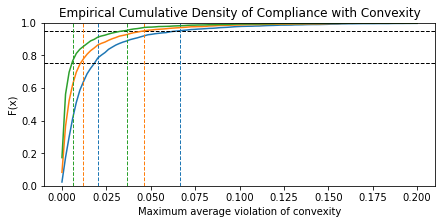

In [10]:
max_violations = np.linspace(0, 0.2, 100)
ecdf_violations = {
    i: np.array([len(df[df["max_violation"] <= max_violation]) / len(df) for max_violation in max_violations]) for i, df in zip([0, 64, 128, 256], [df_convexityviolations_0, df_convexityviolations_64, df_convexityviolations_128, df_convexityviolations_256])
}
#ecdf_violations_128 = np.array([len(df_convexityviolations_128[df_convexityviolations_128["max_violation"] <= max_violation]) / len(df_convexityviolations_128) for max_violation in max_violations])
#ecdf_violations_conditional = np.array([len(df_convexityviolations[df_convexityviolations["avg_violation_conditional"] <= max_violation]) / len(df_convexityviolations) for max_violation in max_violations])
fig, ax = plt.subplots(figsize=(7,3))
ax.set_title("Empirical Cumulative Density of Compliance with Convexity")
ax.set_xlabel("Maximum average violation of convexity")
ax.set_ylabel("F(x)")

for i, offset in enumerate([0, 64, 256]):
    ax.plot(max_violations, ecdf_violations[offset])
    
    for q in [.75, 0.95]:
        data_row = ecdf_violations[offset]
        indices_of_violations = np.where(data_row > q)[0]
        if i == 0:
            ax.axhline(q, color="black", linestyle="--", linewidth=1)
        if len(indices_of_violations) > 0:
            ax.axvline(max_violations[indices_of_violations[0]], color=f"C{i}", linestyle="--", linewidth=1)
ax.set_ylim([0, 1])
fig.savefig("plots/violations_convexity.pdf", bbox_inches='tight')

## Peaking / Double Descent

In [11]:
def get_double_descent(df, column, l, eps = 0.02, delta = 0.005):
    rows = []
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = np.array(df_learner["sizes"].values[0])
            scores = df_learner[column].values[0]
            
            if sizes[-1] < l:
                continue
            
            min_index = np.where(sizes >= l)[0][0]
            sizes = sizes[min_index:]
            scores = scores[min_index:]
            
            deteriorations = [i for i, s in enumerate(scores) if i > 0 and i < len(scores) - 1 and s < scores[i + 1] - eps]
            is_double_descent = False
            if len(deteriorations) > 0: # there exists a deterioration, now check whether it improves again
                
                sink_start = scores[deteriorations[0]]
                tail = scores[deteriorations[0] + 1:]
                rescue = np.where(tail[1:] < sink_start)[0]
                
                if len(rescue) > 0: # this is really a peak
                    all_good = [tail[rescue[i]] + delta > tail[rescue[i + 1]] for i in range(len(rescue) - 1)]
                    if len(all_good) > 0:
                        is_double_descent = (np.count_nonzero(all_good) / len(all_good)) > .8
            
            rows.append([openmlid, learner, is_double_descent])
            
    return pd.DataFrame(rows, columns=["openmlid", "learner", "is_double_descent"])

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

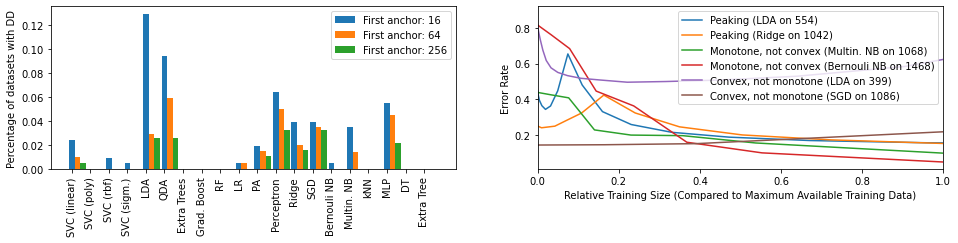

In [12]:
fig, (ax_bar, ax_curves) = plt.subplots(1, 2, figsize=(16, 3))

for i, offset in enumerate([16, 64, 256]):
    df_doubledescent = get_double_descent(df_mean_curves, "mean_errorrates", offset, eps = 0.05, delta = 0.01)
    ax_bar.bar(np.array(range(len(learners))) + i * 0.3, height=[np.mean(df_doubledescent[df_doubledescent["learner"] == l]["is_double_descent"]) for l in learners], width=0.3, label=f"First anchor: {offset}")
    
    if offset == 64:
        for openmlid, learner in df_doubledescent[df_doubledescent["is_double_descent"]].values[[9, 28],:2]:
            violating_curve = df_mean_curves[(df_mean_curves["openmlid"] == openmlid) & (df_mean_curves["learner"] == learner)].iloc[0]
            sizes = np.array(violating_curve["sizes"])
            ax_curves.plot((sizes - 64) / min(6000, max(sizes - 64)), violating_curve["mean_errorrates"], label=f"Peaking ({learner_names[learners.index(learner)]} on {openmlid})")

# plot convex and non-monotone curves (and the other way around)
df_properties_64 = df_monotonicityviolations_64.rename(columns={"max_violation": "violation_mono"})[["openmlid", "learner", "violation_mono"]].merge(df_convexityviolations_64.rename(columns={"max_violation": "violation_convex"})[["openmlid", "learner", "violation_convex"]], on=["openmlid", "learner"]).merge(get_double_descent(df_mean_curves, "mean_errorrates", 64, eps = 0.05, delta = 0.01), on=["openmlid", "learner"])
p1 = df_properties_64["violation_mono"] > 0.05
np1 = df_properties_64["violation_mono"] == 0
p2 = df_properties_64["violation_convex"] > 0.05
np2 = df_properties_64["violation_convex"] == 0
p3 = df_properties_64["is_double_descent"]
for i, row in df_properties_64[np1 & p2].head(2).iterrows():
    curve = df_mean_curves[(df_mean_curves["openmlid"] == row["openmlid"]) & (df_mean_curves["learner"] == row["learner"])].iloc[0]
    sizes = np.array(curve["sizes"])
    ax_curves.plot((sizes - 64) / max(sizes - 64), curve["mean_errorrates"], label=f"Monotone, not convex ({learner_names[learners.index(row['learner'])]} on {row['openmlid']})")
for i, row in df_properties_64[p1 & np2].head(2).iterrows():
    curve = df_mean_curves[(df_mean_curves["openmlid"] == row["openmlid"]) & (df_mean_curves["learner"] == row["learner"])].iloc[0]
    sizes = np.array(curve["sizes"])
    ax_curves.plot((sizes - 64) / max(sizes - 64), curve["mean_errorrates"], label=f"Convex, not monotone ({learner_names[learners.index(row['learner'])]} on {row['openmlid']})")
ax_curves.set_xlabel("Relative Training Size (Compared to Maximum Available Training Data)")
ax_curves.set_ylabel("Error Rate")
ax_curves.legend()
ax_curves.set_xlim([0, 1])

ax_bar.set_xticks(range(len(learners)))
ax_bar.set_xticklabels(learner_names, rotation=90)
ax_bar.set_ylabel("Percentage of datasets with DD")
ax_bar.legend()
fig.savefig("plots/curveproperties.pdf", bbox_inches='tight')

# Curve Intersections

In [13]:
def get_intersections(df, column):
    rows = []
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for l1, l2 in it.product(pd.unique(df_dataset["learner"]), pd.unique(df_dataset["learner"])):
            
            df1 = df_dataset[df_dataset["learner"] == l1]
            df2 = df_dataset[df_dataset["learner"] == l2]
            
            sizes_1 = df1["sizes"].values[0]
            sizes_2 = df2["sizes"].values[0]
            mean_scores_1 = df1[column].values[0]
            mean_scores_2 = df2[column].values[0]
            
            init_margin = mean_scores_1[0] - mean_scores_2[0]
            final_margin = mean_scores_1[-1] > mean_scores_2[-1]
            
            rows.append([openmlid, l1, l2, init_margin, final_margin])
            
    return pd.DataFrame(rows, columns=["openmlid", "learner 1", "learner 2", "init margin", "final margin"])
    
df_intersections = get_intersections(df_mean_curves, "mean_errorrates")

  0%|          | 0/202 [00:00<?, ?it/s]

In [14]:
eps = 0.005
Z_A = np.zeros((len(learners), len(learners)))
Z_AB = np.zeros((len(learners), len(learners)))
Z_BGIVENA = np.zeros((len(learners), len(learners)))
for i, l1 in enumerate(learners):
    for j, l2 in enumerate(learners):
        df_active = df_intersections[(df_intersections["learner 1"] == l1) & (df_intersections["learner 2"] == l2)]
        event_A = (df_active["init margin"] < -eps)
        event_B = (df_active["final margin"] > eps)
        Z_A[i,j] = np.mean(event_A)
        Z_AB[i,j] = np.mean(event_A & event_B)
        Z_BGIVENA[i,j] = Z_AB[i,j] / Z_A[i,j]

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


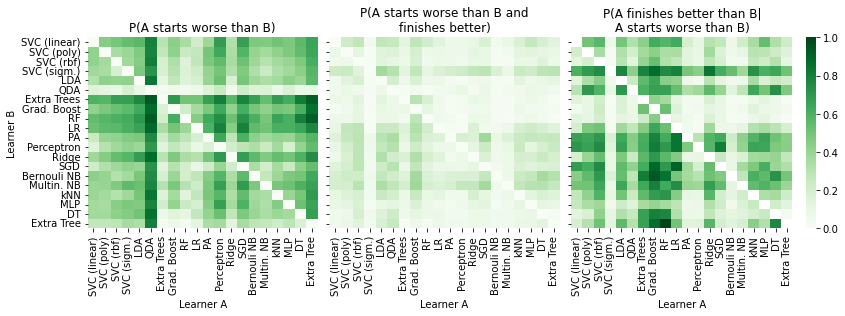

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4.5), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1.2]})
for a, Z, t in zip(ax, [Z_A, Z_AB, Z_BGIVENA], ["P(A starts worse than B)", "P(A starts worse than B and\nfinishes better)", "P(A finishes better than B|\nA starts worse than B)"]):
    is_left = a == ax[0]
    is_right = a == ax[2]
    sns.heatmap(Z, vmin=0, vmax=1, cmap="Greens", ax=a, cbar = is_right)
    a.set_xticks(np.array(range(len(learners))) + 0.5)
    a.set_yticks(np.array(range(len(learners))) + 0.5)
    a.set_xticklabels(learner_names, rotation=90)
    a.set_yticklabels(learner_names, rotation=0)
    a.set_xlabel("Learner A")
    if is_left:
        a.set_ylabel("Learner B")
    a.set_title(t)
fig.tight_layout()
plt.show()
fig.savefig("plots/intersections.pdf", bbox_inches='tight')